Score formula to predict critical waterpoint

In [1]:
import sys
sys.path.append('../data/')  
from data_cleaning import clean_data
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
model = joblib.load('rf.pkl')
preproc = joblib.load('prepoc.pkl')

In [3]:
df = pd.read_csv('Test Values-Copy1.csv')

In [4]:
df_cleaned = clean_data(df)

In [5]:
df_cleaned.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'basin',
       'region', 'district_code', 'ward', 'population', 'scheme_management',
       'extraction_type', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type', 'operation_time',
       'top_installer', 'top_funders'],
      dtype='object')

In [6]:
df_preproc = preproc.transform(df_cleaned)

In [21]:
y_test_pred_proba = model.predict_proba(df_preproc)

In [7]:
y_test_pred = model.predict(df_preproc)

In [11]:
df_cleaned['status_group'] = y_test_pred

In [24]:
df_cleaned['fail_type'] = y_test_pred

In [25]:
df_cleaned['proba fail'] = y_test_pred_proba[:, 0]

In [26]:
df_cleaned['proba repairs'] = y_test_pred_proba[:, 1]

In [27]:
df_cleaned["Pop_normalisé"] = (df_cleaned["population"] - df_cleaned["population"].min()) / (df_cleaned["population"].max() - df_cleaned["population"].min())

In [29]:
df_cleaned['water_quality_score']=df_cleaned['water_quality'].map({'soft':1, 'salty': 0.5, 'milky': 0.5, 'unknown': 0.5, 'salty abandoned':0.5, 'coloured':0.5,
       'fluoride':0.5, 'fluoride abandoned':0.5})

In [30]:
df_cleaned['quantity_score'] = df_cleaned['quantity'].map({'enough':1, 'seasonal': 0.75, 'insufficient': 0.5, 'dry': 0.2, 'unknown abandoned':0.2})

In [31]:
df_cleaned['priority_score'] = (df_cleaned['proba fail']+df_cleaned['proba repairs']+df_cleaned['water_quality_score']+df_cleaned['quantity_score']+df_cleaned['Pop_normalisé'])/5

In [36]:
df_cleaned.loc[df_cleaned['fail_type'] == 2, 'priority_score'] = 0

In [56]:
df_cleaned['fail_type'] = df_cleaned['fail_type'].map({2:'functional' ,1: 'functional needs repair',0:'non functional'})

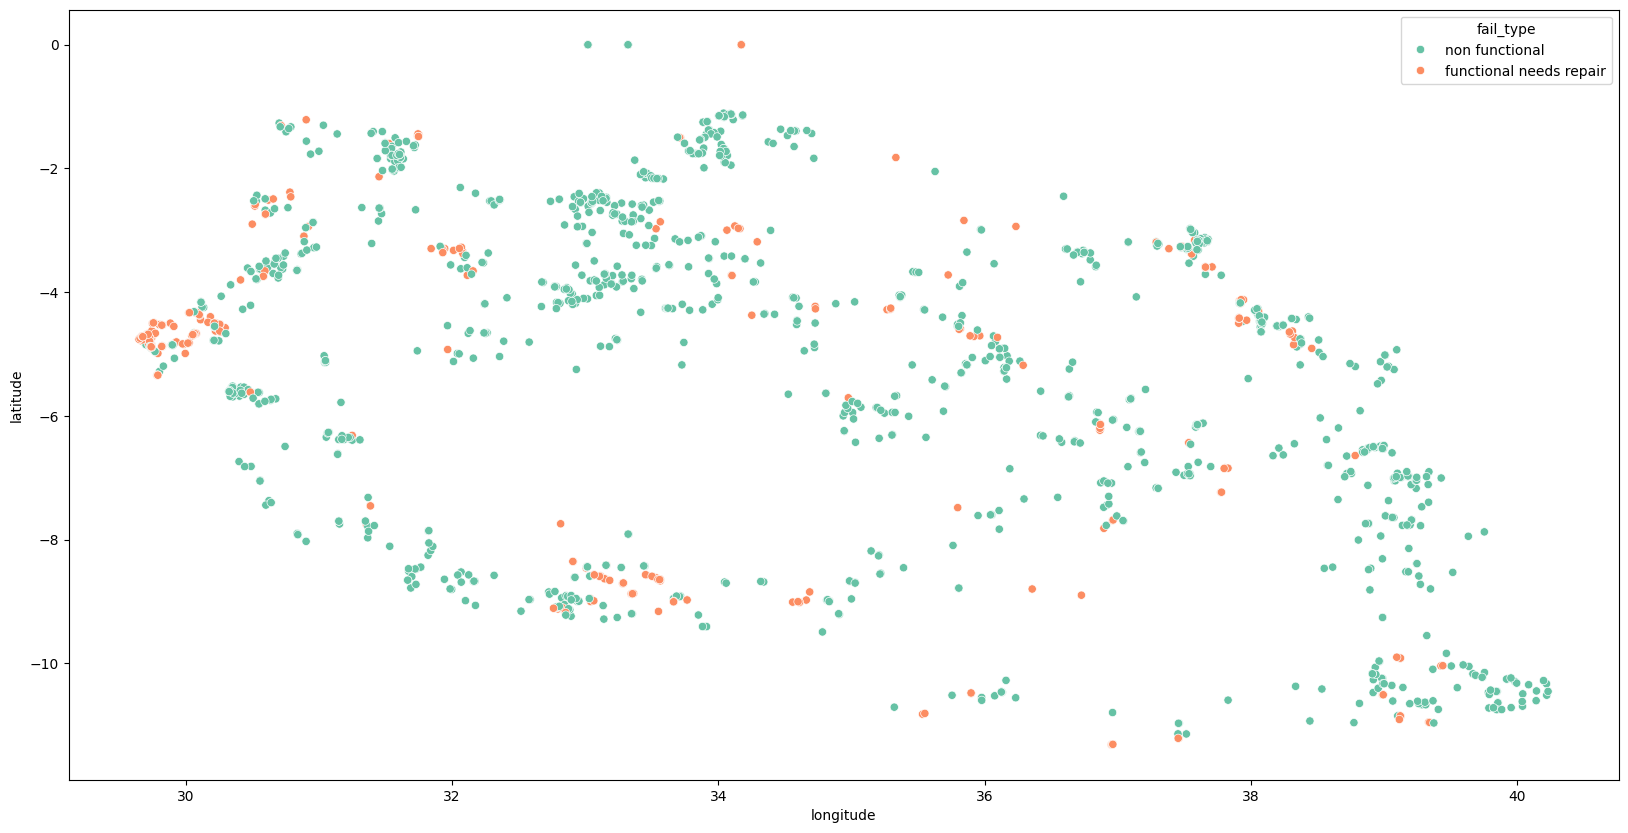

In [72]:
fig, ax  = plt.subplots(figsize=(20,10))
loc_data = df_cleaned.loc[(df_cleaned["priority_score"] > 0.55) & 
                          (df_cleaned["longitude"] > 0) & 
                          (df_cleaned["latitude"] < 0)]
sns.scatterplot(data=loc_data, x="longitude", y="latitude", hue="fail_type",palette = 'Set2')
fig.savefig("map.png", dpi=300)

In [73]:
import plotly.express as px

fig = px.scatter_mapbox(
    df_cleaned,  
    lat="latitude",
    lon="longitude",
    color="priority_score",
    hover_name="fail_type",
    zoom=5,
    range_color=[0, 1] 
)

fig.update_layout(
    sliders=[{
        "active": 0,
        "steps": [{
            "method": "restyle",
            "args": [

                {"visible": df_cleaned["priority_score"] >= score},
                {"title": f"Pumps with Priority Score ≥ {score:.1f}"}
            ],
            "label": f"{score:.1f}" 
        } for score in [i/10 for i in range(0, 11)]] 
    }],
    mapbox_style="open-street-map"
)

fig.show()

In [66]:
fig.write_html("pump_map.html")

In [2]:
df_cleaned.columns

NameError: name 'df_cleaned' is not defined

In [ ]:
df_sub = df_cleaned